In [77]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [125]:
class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    VELOCITY_BOUND = (-10, 10)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        # First 2 indexes are positions, last 2 indexes are velocity.
        self.state: npt.NDArray = np.zeros(4, dtype=np.int32)
        self.state[:2] = self.starts[np.random.choice(self.starts.shape[0]), :].copy()

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.state[2:] += self.ACTIONS[action]

        # Constrain velocity to min and max.
        self.state[2:].clip(*self.VELOCITY_BOUND, out=self.state[2:])

        # Update state.
        self.state[:2] += self.state[2:]

        # Constrain to within racetrack array.
        self.state[:2].clip(0, np.array(self.racetrack.shape) - 1, out=self.state[:2])

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state[:2])] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state[:2])] == 2:
            reward += 10
            done = True

        return self.state, reward, done

In [132]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 250, epsilon: float = 0.1, gamma: float = 0.9) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma

        self.Q: dict = {}
        self.policy: dict = {}
        self.count: dict = {}
        self.rewards: list = [0] * num_iterations

        # Initialize dictionaries.
        for i in range(self.env.racetrack.shape[0]):
            for j in range(self.env.racetrack.shape[1]):
                for k in range(*self.env.VELOCITY_BOUND):
                    for l in range(*self.env.VELOCITY_BOUND):
                        state = (i, j, k, l)
                        self.Q[state] = [0] * self.env.ACTION_SPACE
                        self.policy[state] = [1 / self.env.ACTION_SPACE] * self.env.ACTION_SPACE

                        for action in range(self.env.ACTION_SPACE):
                            self.count[state, action] = 0

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode(training=False)
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - MC Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = tuple(self.env.state)
            action = np.random.choice(self.env.ACTION_SPACE, p=self.policy[state])
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
        
        return episode

    def mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            self.rewards[i] = sum([reward for _, _, reward in episode])
            # print(i, self.rewards[i])

            # Get discounted total returns for each time step.
            returns = []
            total = 0
            for _, _, reward in reversed(episode):
                returns.append(reward + self.gamma * total)
                total += reward
            returns.reverse()

            for t, (state, action, reward) in enumerate(episode):
                self.count[(state, action)] += 1
                self.Q[state][action] += (returns[t] - self.Q[state][action]) / self.count[(state, action)]
                optimal_action = np.argmax(self.Q[state])
                
                for a in self.env.get_actions():
                    if a == optimal_action:
                        self.policy[state][a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state][a] = self.epsilon / self.env.ACTION_SPACE

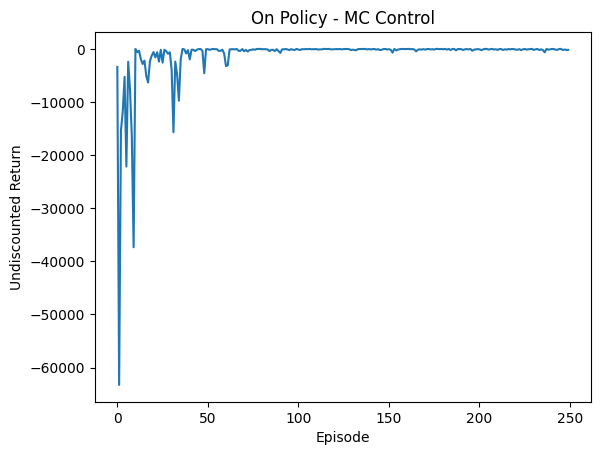

In [133]:
env = Environment("./racetrack.csv")
agent = Agent(env)
agent.mc()
agent.plot_rewards()